In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import shap

from geoshapley import kernel_geoshap_all,attribute_to_X,explain

import warnings

In [2]:
size=50
n = size*size

b0 = np.ones(size*size).reshape(size,size)
b1 = np.ones(size*size).reshape(size,size)
b2 = np.ones(size*size).reshape(size,size)

for i in range(size):
    for j in range(size):
        b0[i][j] = 6/(12.5**4)*(12.5**2-(12.5-i/2)**2)*(12.5**2-(12.5-j/2)**2)
        b1[i,j] = (i+j)/49*3

b2 = np.flip(b1,axis=1).T

b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = np.ones(size*size).reshape(-1)*2

In [65]:
def plot_s(b,sub_title=['','','','',''],title="",non_spatial=[],vmin=None,vmax=None,interpolation=None):
    k = len(b)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4),dpi=300)
    for i in range(k):
        for m in non_spatial:
            if i == m[0]: 
                ax = axs[i].scatter(m[1],m[2],s=5,color="black")
                axs[i].set_ylim([m[3],m[4]])
                axs[i].set_xlim([-2.5,2.5])
                #axs[i].set_ylabel(r'$\phi_{}$'.format(i),fontsize=16)
                axs[i].set_xlabel(r'$X_{}$'.format(i),fontsize=16)
                
                break
                
        else:
            ax = axs[i].imshow(b[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
                               vmin=vmin,vmax=vmax,interpolation=interpolation)
        
            fig.colorbar(ax, ax=axs[i])

            axs[i].set_xticks(np.arange(-0.5, size, 5))
            axs[i].set_yticks(np.arange(-0.5, size, 5))
            axs[i].set_xticklabels([])
            axs[i].set_yticklabels([])
        
            axs[i].tick_params(axis='x', colors=(0,0,0,0))
            axs[i].tick_params(axis='y', colors=(0,0,0,0))
        
        axs[i].set_title(sub_title[i],fontsize=18,y=1.05)
    
    #fig.suptitle(title, fontsize=25,y=1.1)
    
    plt.savefig(title + ".png",bbox_inches='tight')

In [4]:
np.random.seed(222)

X1 = np.random.uniform(-2,2,size*size)
X2 = np.random.uniform(-2,2,size*size)
X3 = np.random.uniform(-2,2,size*size)
X4 = np.random.uniform(-2,2,size*size)

err = np.random.randn(size*size)

X = np.vstack([X1,X2,X3,X4]).T

u = np.array([np.linspace(0,size-1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size-1,num=size)]*size).T.reshape(-1)
coords = list(zip(u,v))

k = X.shape[1];n = X.shape[0]

In [5]:
names=['X1','X2','X3','X4','x_coord','y_coord']

X_coords = pd.DataFrame(np.concatenate([X,np.array(coords)],axis=1),columns=names)

X_coords = X_coords - X_coords.mean(axis=0)

In [6]:
f0 = b0
f1 = b1*X_coords.values[:,0]
f2 = b2*X_coords.values[:,1]
f3 = b3*X_coords.values[:,2]
f4 = X_coords.values[:,3]**2

y = pd.DataFrame(f0 + f1 + f2 + f3 + f4 + err,columns=['y'])
#y = y - y.mean()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


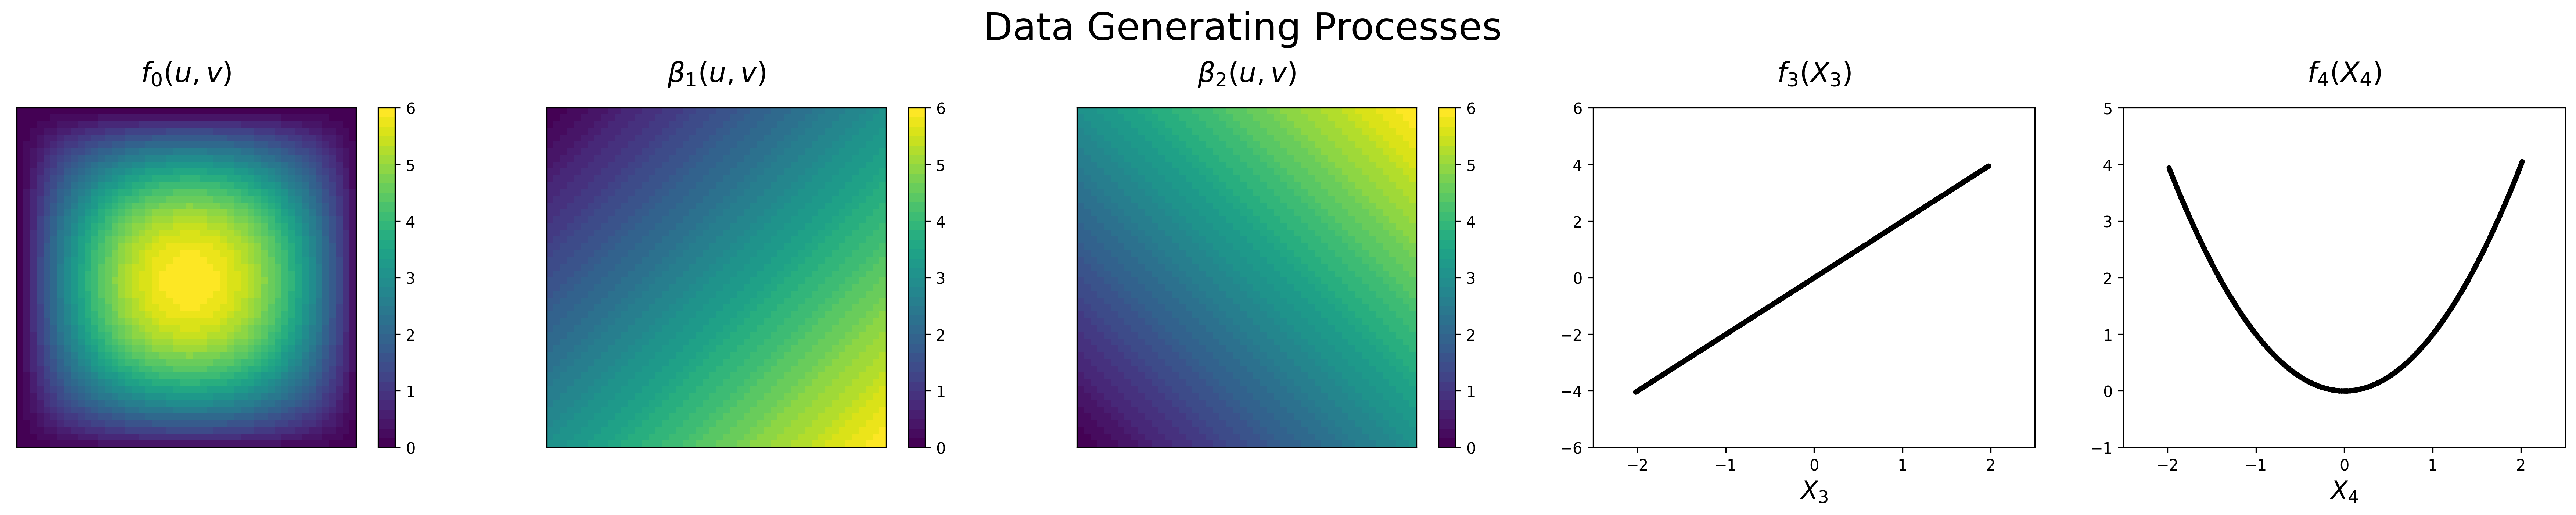

In [7]:
sub_t = [r"$f_0(u,v)$",r"$\beta_1(u,v)$",r"$\beta_2(u,v)$",r"$f_{3}(X_{3})$", r"$f_{4}(X_{4})$"]
plot_s(np.vstack([b0,b1,b2,b3,b2]),sub_title=sub_t,vmin=0,vmax=6,title="Data Generating Processes",
       non_spatial=[[3,X_coords.values[:,2], f3,-6,6],
                    [4,X_coords.values[:,3], f4,-1,5]])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_coords, y.values.reshape(-1),random_state=1)

In [9]:
from hpsklearn import HyperoptEstimator, random_forest_regressor,mlp_regressor,svr
from hpsklearn import xgboost_regression,gaussian_process_regressor,linear_regression
from hyperopt import tpe

In [10]:
def train_any_model(any_regressor,max_evals=200):
    estim = HyperoptEstimator(regressor=any_regressor("mySVR"),
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=240)
    estim.fit(X_train, y_train)
    return estim

In [11]:
%%time
ols_model = train_any_model(linear_regression)

100%|████████████████| 200/200 [00:01<00:00,  1.12s/trial, best loss: 0.22654148683104203]
CPU times: user 2.42 s, sys: 1.7 s, total: 4.13 s
Wall time: 3min 33s


In [12]:
%%time
warnings.filterwarnings('ignore')
for i in range(0,100):
    try:
        mlp_model = train_any_model(mlp_regressor)
        break
    except:
        pass

 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 67%|███████████████████████████████▎               | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (210) reached and the optimization hasn't converged yet.
  warnings.warn(


 88%|█████████████████████████████████████████▏     | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (270) reached and the optimization hasn't converged yet.
  warnings.warn(


 91%|████████████████████████████████████████▉    | 10/11 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 93%|█████████████████████████████████████████▊   | 13/14 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (345) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/n

 67%|███████████████████████████████▎               | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (167) reached and the optimization hasn't converged yet.
  warnings.warn(


 90%|█████████████████████████████████████████▍    | 9/10 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 92%|█████████████████████████████████████████▌   | 12/13 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 93%|█████████████████████████████████████████▊   | 13/14 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (199) reached and the optimization hasn't converged yet.
  warnings.warn(


 93%|██████████████████████████████████████████   | 14/15 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (253) reached and the optimization hasn't converged yet.
  warnings.warn(


 94%|██████████████████████████████████████████▏  | 15/16 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (226) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▋  | 18/19 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (175) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▊  | 19/20 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (254) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▊  | 20/21 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (194) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▉  | 21/22 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████  | 22/23 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▏ | 24/25 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▎ | 26/27 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▌ | 30/31 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▌ | 31/32 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (269) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▋ | 32/33 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (245) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▊ | 36/37 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▊ | 37/38 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (214) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (232) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite

 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 67%|███████████████████████████████▎               | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (189) reached and the optimization hasn't converged yet.
  warnings.warn(


 75%|███████████████████████████████████▎           | 3/4 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 88%|█████████████████████████████████████████▏     | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 92%|█████████████████████████████████████████▎   | 11/12 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (348) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 67%|███████████████████████████████▎               | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 88%|█████████████████████████████████████████▏     | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 89%|█████████████████████████████████████████▊     | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 92%|█████████████████████████████████████████▎   | 11/12 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (170) reached and the optimization hasn't converged yet.
  warnings.warn(


 94%|██████████████████████████████████████████▏  | 15/16 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (311) reached and the optimization hasn't converged yet.
  warnings.warn(


 94%|██████████████████████████████████████████▌  | 17/18 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 95%|██████████████████████████████████████████▊  | 20/21 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (335) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▉  | 21/22 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▏ | 23/24 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▋ | 34/35 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (210) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 67%|███████████████████████████████▎               | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:6

 89%|█████████████████████████████████████████▊     | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (206) reached and the optimization hasn't converged yet.
  warnings.warn(


 91%|████████████████████████████████████████▉    | 10/11 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (185) reached and the optimization hasn't converged yet.
  warnings.warn(


 92%|█████████████████████████████████████████▎   | 11/12 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (174) reached and the optimization hasn't converged yet.
  warnings.warn(


 93%|█████████████████████████████████████████▊   | 13/14 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (223) reached and the optimization hasn't converged yet.
  warnings.warn(


 94%|██████████████████████████████████████████▏  | 15/16 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 94%|██████████████████████████████████████████▎  | 16/17 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 95%|██████████████████████████████████████████▊  | 19/20 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (336) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▉  | 21/22 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████  | 22/23 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▏ | 23/24 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▏ | 24/25 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▎ | 25/26 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▍ | 27/28 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▍ | 28/29 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (257) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▋ | 34/35 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▊ | 36/37 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▊ | 37/38 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 98%|████████████████████████████████████████████ | 44/45 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (347) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



  0%|                                               | 0/1 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (248) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 80%|█████████████████████████████████████▌         | 4/5 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (158) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (213) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data ma

 67%|███████████████████████████████▎               | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 89%|█████████████████████████████████████████▊     | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (197) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 92%|█████████████████████████████████████████▎   | 11/12 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 92%|█████████████████████████████████████████▌   | 12/13 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 93%|█████████████████████████████████████████▊   | 13/14 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 93%|██████████████████████████████████████████   | 14/15 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (301) reached and the optimization hasn't converged yet.
  warnings.warn(


 94%|██████████████████████████████████████████▎  | 16/17 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (255) reached and the optimization hasn't converged yet.
  warnings.warn(


 96%|███████████████████████████████████████████▏ | 24/25 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (285) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 67%|███████████████████████████████▎               | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (229) reached and the optimization hasn't converged yet.
  warnings.warn(


 80%|█████████████████████████████████████▌         | 4/5 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (278) reached and the optimization hasn't converged yet.
  warnings.warn(


 86%|████████████████████████████████████████▎      | 6/7 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 88%|█████████████████████████████████████████▏     | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 90%|█████████████████████████████████████████▍    | 9/10 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (323) reached and the optimization hasn't converged yet.
  warnings.warn(


 91%|████████████████████████████████████████▉    | 10/11 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (302) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (206) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 83%|███████████████████████████████████████▏       | 5/6 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 86%|████████████████████████████████████████▎      | 6/7 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (292) reached and the optimization hasn't converged yet.
  warnings.warn(


 93%|██████████████████████████████████████████   | 14/15 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 94%|██████████████████████████████████████████▎  | 16/17 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (178) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▋  | 18/19 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (192) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 75%|███████████████████████████████████▎           | 3/4 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (322) reached and the optimization hasn't converged yet.
  warnings.warn(


 89%|█████████████████████████████████████████▊     | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (343) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (336) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (243) reached and the optimization hasn't converged yet.
  warnings.warn(


 75%|███████████████████████████████████▎           | 3/4 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (270) reached and the optimization hasn't converged yet.
  warnings.warn(


 80%|█████████████████████████████████████▌         | 4/5 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (275) reached and the optimization hasn't converged yet.
  warnings.warn(


 88%|█████████████████████████████████████████▏     | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (214) reached and the optimization hasn't converged yet.
  warnings.warn(


 92%|█████████████████████████████████████████▌   | 12/13 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 95%|██████████████████████████████████████████▋  | 18/19 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (342) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▋ | 33/34 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 97%|███████████████████████████████████████████▊ | 36/37 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 98%|███████████████████████████████████████████▉ | 39/40 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 98%|███████████████████████████████████████████▉ | 42/43 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (262) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data ma

 50%|███████████████████████▌                       | 1/2 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (196) reached and the optimization hasn't converged yet.
  warnings.warn(


 80%|█████████████████████████████████████▌         | 4/5 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 92%|█████████████████████████████████████████▎   | 11/12 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (205) reached and the optimization hasn't converged yet.
  warnings.warn(


 94%|██████████████████████████████████████████▏  | 15/16 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▍ | 27/28 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (292) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▋ | 33/34 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (201) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▋ | 34/35 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (255) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data ma

100%|█████████████████████| 2/2 [00:02<00:00,  2.03s/trial, best loss: 0.0424000929502234]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (308) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|█████████████████████████████████████▌         | 4/5 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 88%|█████████████████████████████████████████▏     | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 90%|█████████████████████████████████████████▍    | 9/10 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (233) reached and the optimization hasn't converged yet.
  warnings.warn(


 91%|████████████████████████████████████████▉    | 10/11 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (293) reached and the optimization hasn't converged yet.
  warnings.warn(


 92%|█████████████████████████████████████████▎   | 11/12 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 93%|█████████████████████████████████████████▊   | 13/14 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 94%|██████████████████████████████████████████▎  | 16/17 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 94%|██████████████████████████████████████████▌  | 17/18 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 95%|██████████████████████████████████████████▊  | 20/21 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (205) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▉  | 21/22 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (152) reached and the optimization hasn't converged yet.
  warnings.warn(


 96%|███████████████████████████████████████████  | 22/23 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (213) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████ | 49/50 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (181) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▏| 51/52 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 98%|████████████████████████████████████████████▏| 56/57 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 98%|████████████████████████████████████████████▎| 59/60 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (212) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▎| 61/62 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (187) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▎| 65/66 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▍| 75/76 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▍| 82/83 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▍| 85/86 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▍| 87/88 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:173: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_base.py:128: RuntimeWarning: invalid value encountered in multiply
  delta *= 1 - Z**2
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (210) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 75%|███████████████████████████████████▎           | 3/4 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (164) reached and the optimization hasn't converged yet.
  warnings.warn(


 89%|█████████████████████████████████████████▊     | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (290) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (182) reached and the optimization hasn't converged yet.
  warnings.warn(
job exception: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.



 83%|███████████████████████████████████████▏       | 5/6 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 86%|████████████████████████████████████████▎      | 6/7 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (216) reached and the optimization hasn't converged yet.
  warnings.warn(


 88%|█████████████████████████████████████████▏     | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 89%|█████████████████████████████████████████▊     | 8/9 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 95%|██████████████████████████████████████████▋  | 18/19 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (162) reached and the optimization hasn't converged yet.
  warnings.warn(


 95%|██████████████████████████████████████████▊  | 19/20 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 95%|██████████████████████████████████████████▉  | 21/22 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████  | 22/23 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▏ | 23/24 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (277) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 96%|███████████████████████████████████████████▏ | 24/25 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (272) reached and the optimization hasn't converged yet.
  warnings.warn(


 96%|███████████████████████████████████████████▎ | 26/27 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (319) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▌ | 29/30 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (248) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▌ | 30/31 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (197) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▋ | 34/35 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (169) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▊ | 36/37 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (172) reached and the optimization hasn't converged yet.
  warnings.warn(


 97%|███████████████████████████████████████████▊ | 37/38 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (202) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|███████████████████████████████████████████▉ | 40/41 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (179) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|███████████████████████████████████████████▉ | 41/42 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (190) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|███████████████████████████████████████████▉ | 42/43 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (205) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████ | 47/48 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████ | 49/50 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (290) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▏| 52/53 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (210) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▏| 56/57 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (185) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▏| 58/59 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (259) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▎| 59/60 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 98%|████████████████████████████████████████████▎| 61/62 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (246) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▎| 62/63 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (173) reached and the optimization hasn't converged yet.
  warnings.warn(


 98%|████████████████████████████████████████████▎| 65/66 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (184) reached and the optimization hasn't converged yet.
  warnings.warn(


 99%|████████████████████████████████████████████▎| 69/70 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (277) reached and the optimization hasn't converged yet.
  warnings.warn(


 99%|████████████████████████████████████████████▍| 71/72 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (219) reached and the optimization hasn't converged yet.
  warnings.warn(


 99%|████████████████████████████████████████████▍| 72/73 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (235) reached and the optimization hasn't converged yet.
  warnings.warn(


 99%|████████████████████████████████████████████▍| 86/87 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▍| 87/88 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▍| 88/89 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▌| 92/93 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▌| 93/94 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▌| 96/97 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▌| 97/98 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|████████████████████████████████████████████▌| 98/99 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▌| 103/104 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▌| 104/105 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▌| 107/108 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▌| 110/111 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▌| 113/114 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 115/116 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 116/117 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 119/120 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 126/127 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 133/134 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 139/140 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 142/143 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 143/144 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 155/156 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 157/158 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 158/159 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 159/160 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 163/164 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 164/165 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 166/167 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (186) reached and the optimization hasn't converged yet.
  warnings.warn(


 99%|██████████████████████████████████████████▋| 167/168 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 168/169 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▋| 170/171 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 172/173 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 173/174 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 175/176 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


100%|███████████████| 176/176 [00:09<00:00,  9.09s/trial, best loss: 0.026866220221804293]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



 99%|██████████████████████████████████████████▊| 178/179 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 182/183 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 183/184 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 184/185 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 185/186 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (236) reached and the optimization hasn't converged yet.
  warnings.warn(


100%|███████████████| 186/186 [00:08<00:00,  8.52s/trial, best loss: 0.026866220221804293]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



100%|███████████████| 187/187 [00:07<00:00,  7.62s/trial, best loss: 0.026866220221804293]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



 99%|██████████████████████████████████████████▊| 190/191 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 191/192 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 193/194 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


 99%|██████████████████████████████████████████▊| 196/197 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


100%|███████████████| 198/198 [00:10<00:00, 10.08s/trial, best loss: 0.026866220221804293]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



100%|███████████████| 200/200 [00:02<00:00,  2.20s/trial, best loss: 0.026866220221804293]
CPU times: user 1min 3s, sys: 11.9 s, total: 1min 15s
Wall time: 28min 13s


In [13]:
%%time
rf_model = train_any_model(random_forest_regressor)

100%|████████████████| 200/200 [00:06<00:00,  6.19s/trial, best loss: 0.08405166038645762]
CPU times: user 19.5 s, sys: 2.96 s, total: 22.4 s
Wall time: 48min 19s


In [14]:
%%time
xgb_model = train_any_model(xgboost_regression)

100%|████████████████| 200/200 [00:02<00:00,  2.01s/trial, best loss: 0.03532048623634265]
CPU times: user 6.59 s, sys: 1.85 s, total: 8.44 s
Wall time: 6min 12s


In [15]:
%%time
gp_model = train_any_model(gaussian_process_regressor)

100%|███████████████| 200/200 [00:10<00:00, 10.19s/trial, best loss: 0.028298973435600838]
CPU times: user 15 s, sys: 17.7 s, total: 32.7 s
Wall time: 17min 7s


In [16]:
%%time
svm_model = train_any_model(svr)

100%|███████████████| 200/200 [00:01<00:00,  1.56s/trial, best loss: 0.029094514017760975]
CPU times: user 1min 22s, sys: 4.96 s, total: 1min 27s
Wall time: 57min 2s


In [17]:
print(ols_model.score(X_test, y_test))
print(rf_model.score(X_test, y_test))
print(xgb_model.score(X_test, y_test))
print(svm_model.score(X_test, y_test))
print(gp_model.score(X_test, y_test))
print(mlp_model.score(X_test, y_test))

0.7574520472311126
0.9063405997680184
0.9636975568562242
0.9686058977043741
0.9708777897910673
0.9711821576286946


In [18]:
print("True R2:", 1 - np.sum((err)**2)/np.sum((y-y.mean())**2).values[0])

True R2: 0.974733255055843


In [19]:
%%time
#background_X = X_coords.values#.sample(frac=1).values
#background_X = X_coords.sample(n=100).values
background_X = np.zeros((1,X_coords.shape[1]))

CPU times: user 55 µs, sys: 134 µs, total: 189 µs
Wall time: 31.2 µs


In [20]:
%%time
mlp_exp_rslt = explain(mlp_model, X_coords, background_X);
ols_exp_rslt = explain(ols_model, X_coords, background_X);
svm_exp_rslt = explain(svm_model, X_coords, background_X);
gp_exp_rslt = explain(gp_model, X_coords, background_X);
rf_exp_rslt = explain(rf_model, X_coords, background_X);
xgb_exp_rslt = explain(xgb_model, X_coords, background_X);

Adds up to total: True


Adds up to total: True


Adds up to total: True


Adds up to total: True


Adds up to total: True


Adds up to total: True
CPU times: user 6min 33s, sys: 2min 21s, total: 8min 54s
Wall time: 1min 7s


In [83]:
ols_params = attribute_to_X(ols_exp_rslt, X_coords, background_X,[0, 1])
mlp_params = attribute_to_X(mlp_exp_rslt, X_coords, background_X, coef_col = [0, 1])
svm_params = attribute_to_X(svm_exp_rslt, X_coords, background_X, coef_col = [0, 1])
gp_params = attribute_to_X(gp_exp_rslt, X_coords, background_X, coef_col = [0, 1])
rf_params = attribute_to_X(rf_exp_rslt, X_coords, background_X, coef_col = [0, 1])
xgb_params = attribute_to_X(xgb_exp_rslt, X_coords, background_X, coef_col = [0, 1])

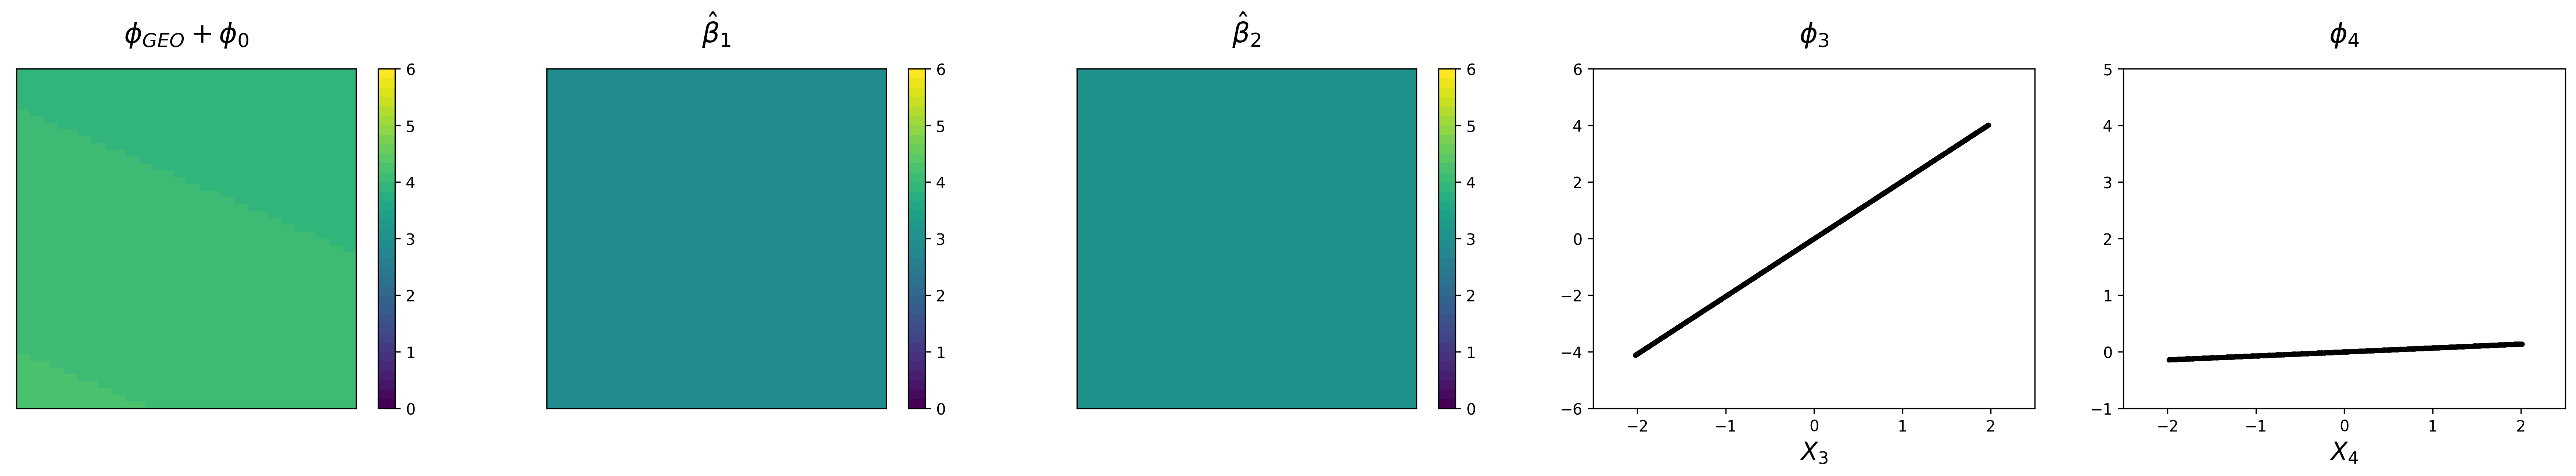

In [84]:
sub_t = [r"$\phi_{GEO}+\phi_{0}$",r"$\hat{\beta}_1$",r"$\hat{\beta}_2$",r"$\phi_{3}$", r"$\phi_{4}$"]

plot_s(ols_params.T,sub_title=sub_t, title="LR", vmin=0,vmax=6,non_spatial=[
                                                           [3,X_coords.values[:,2],ols_params[:,3],-6,6],
                                                           [4,X_coords.values[:,3],ols_params[:,4],-1,5]])

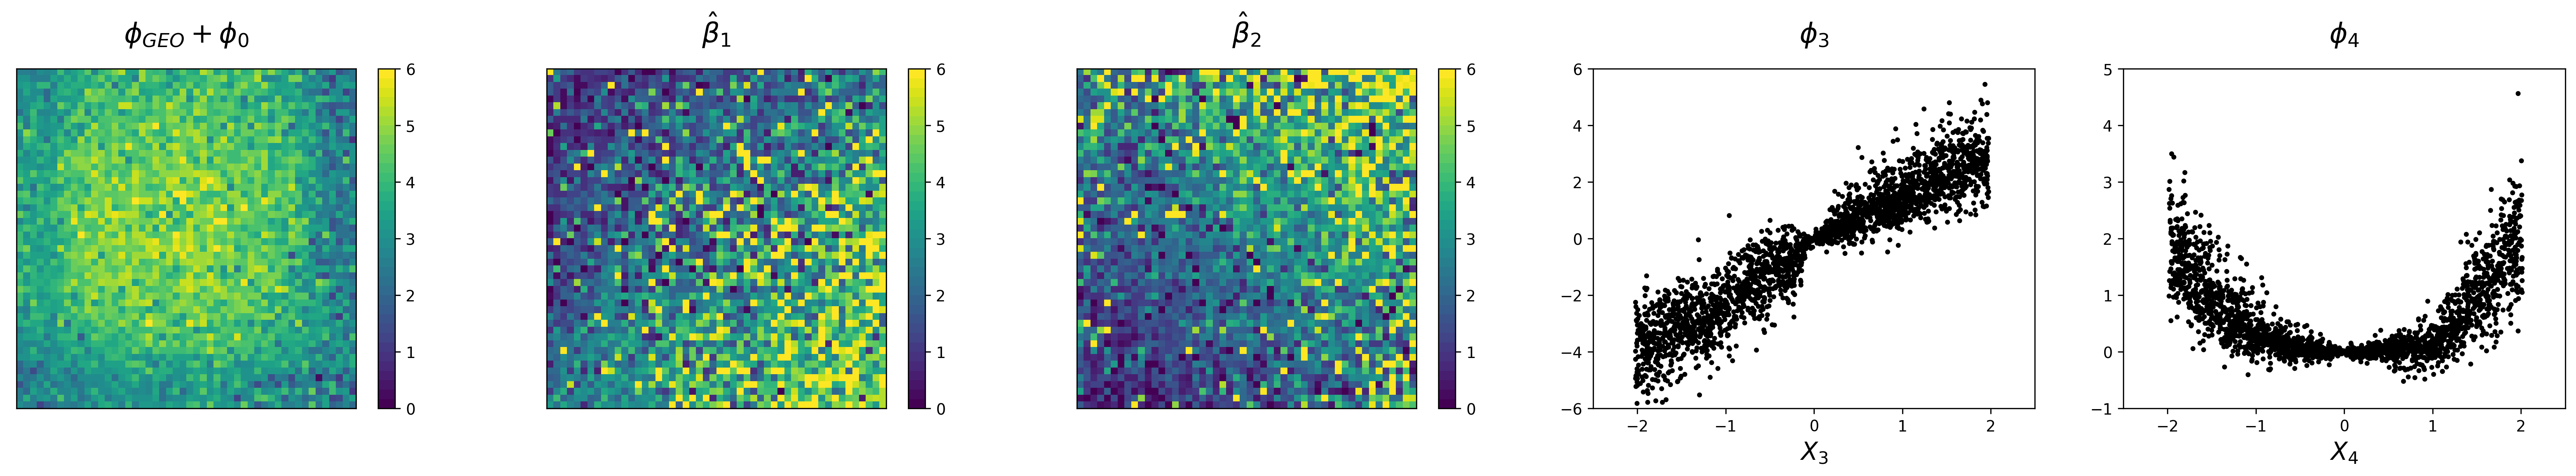

In [76]:
sub_t = [r"$\phi_{GEO}+\phi_{0}$",r"$\hat{\beta}_1$",r"$\hat{\beta}_2$",r"$\phi_{3}$", r"$\phi_{4}$"]

plot_s(rf_params.T,vmin=0,vmax=6,sub_title=sub_t,title="RF",non_spatial=[[3,X_coords.values[:,2],rf_params[:,-2],-6,6],
                                       [4,X_coords.values[:,3],rf_params[:,-1],-1,5]])

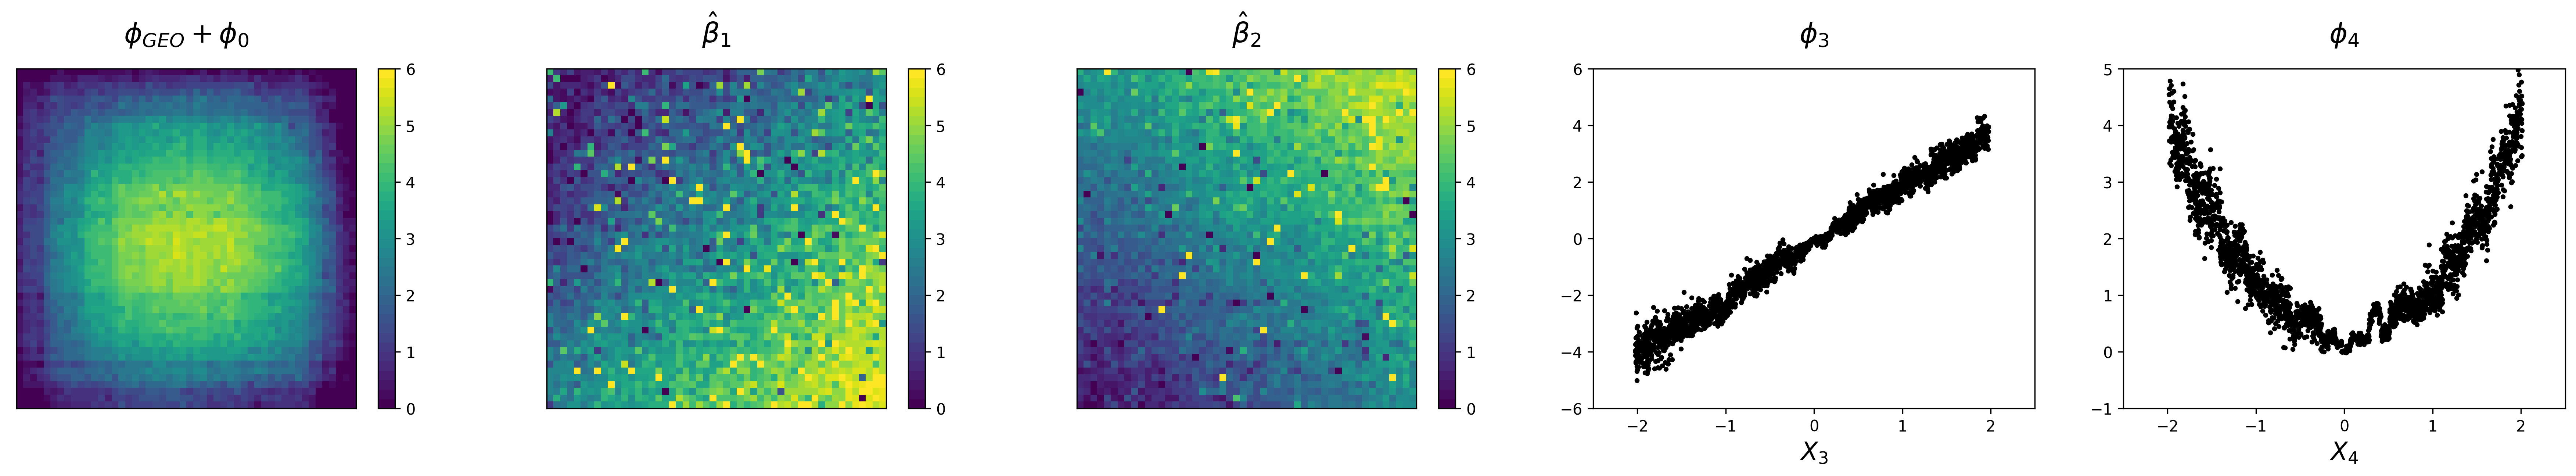

In [77]:
sub_t = [r"$\phi_{GEO}+\phi_{0}$",r"$\hat{\beta}_1$",r"$\hat{\beta}_2$",r"$\phi_{3}$", r"$\phi_{4}$"]

plot_s(xgb_params.T,vmin=0,vmax=6,sub_title=sub_t,title="XGB",non_spatial=[[3,X_coords.values[:,2],xgb_params[:,-2],-6,6],
                                       [4,X_coords.values[:,3],xgb_params[:,-1],-1,5]])

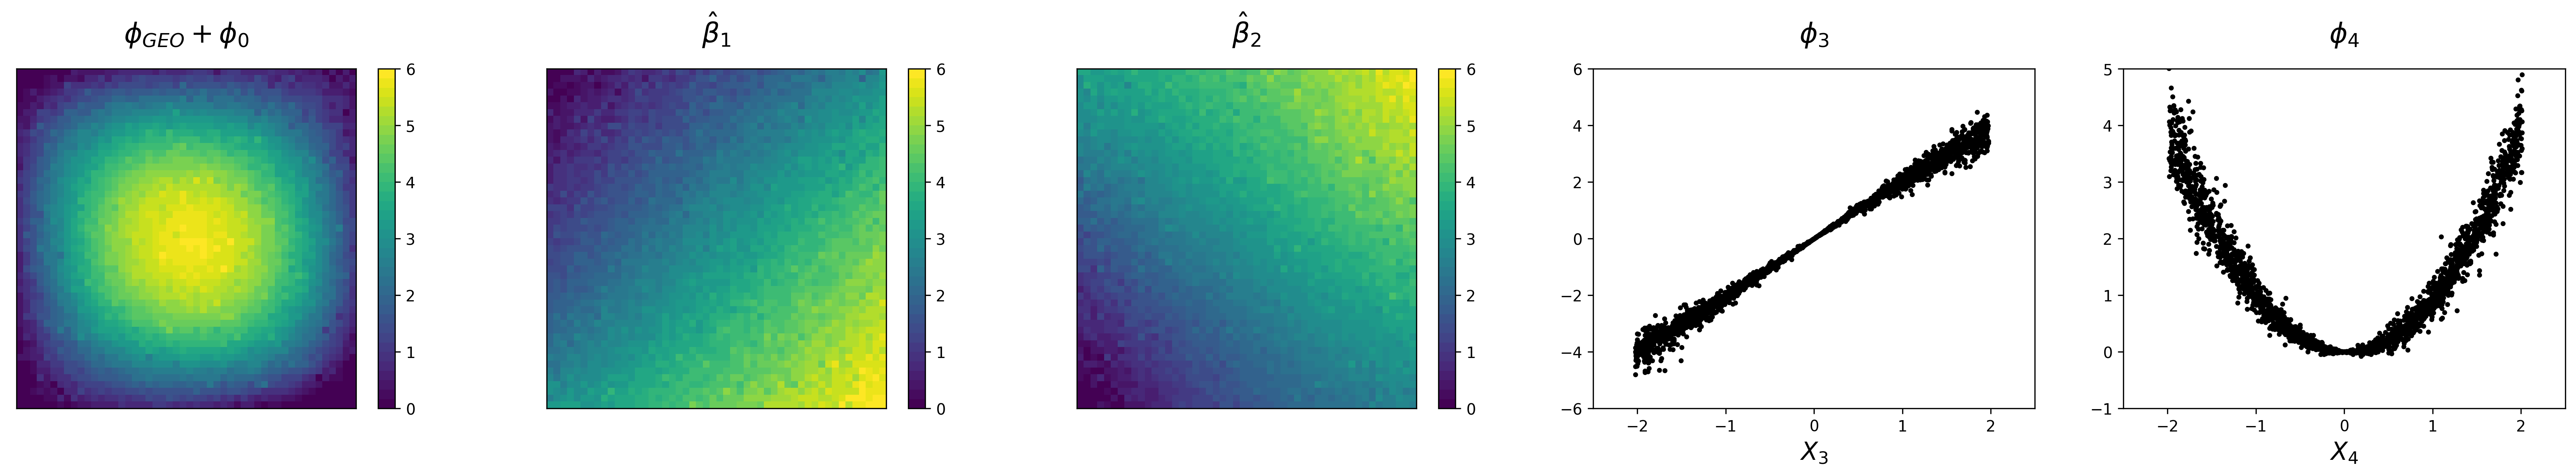

In [78]:
sub_t = [r"$\phi_{GEO}+\phi_{0}$",r"$\hat{\beta}_1$",r"$\hat{\beta}_2$",r"$\phi_{3}$", r"$\phi_{4}$"]

plot_s(svm_params.T,vmin=0,vmax=6,sub_title=sub_t,title="SVM",non_spatial=[[3,X_coords.values[:,2],svm_params[:,-2],-6,6],
                                       [4,X_coords.values[:,3],svm_params[:,-1],-1,5]])

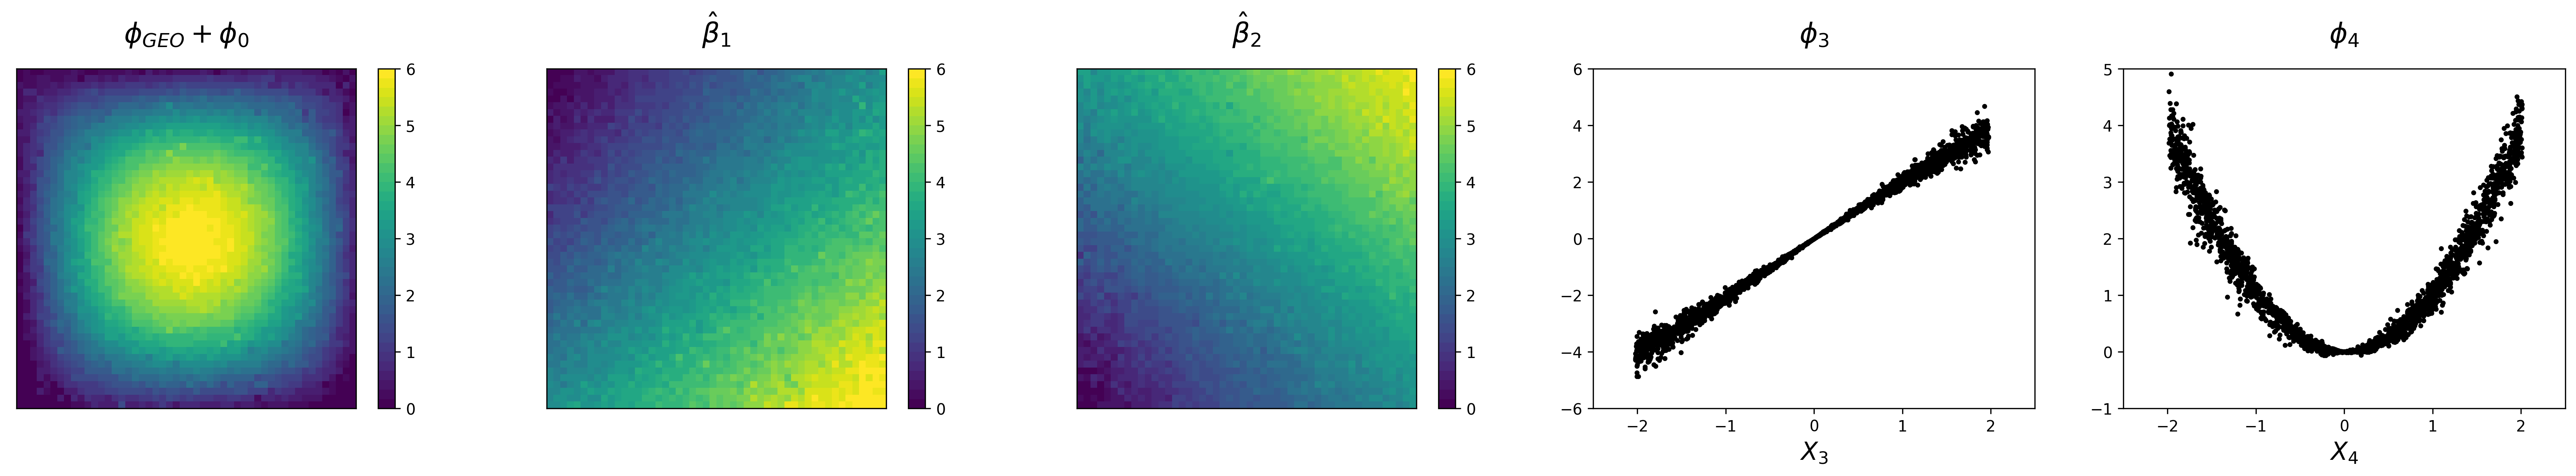

In [79]:
sub_t = [r"$\phi_{GEO}+\phi_{0}$",r"$\hat{\beta}_1$",r"$\hat{\beta}_2$",r"$\phi_{3}$", r"$\phi_{4}$"]

plot_s(gp_params.T,vmin=0,vmax=6,sub_title=sub_t,title="GP",non_spatial=[[3,X_coords.values[:,2],gp_params[:,-2],-6,6],
                                       [4,X_coords.values[:,3],gp_params[:,-1],-1,5]])

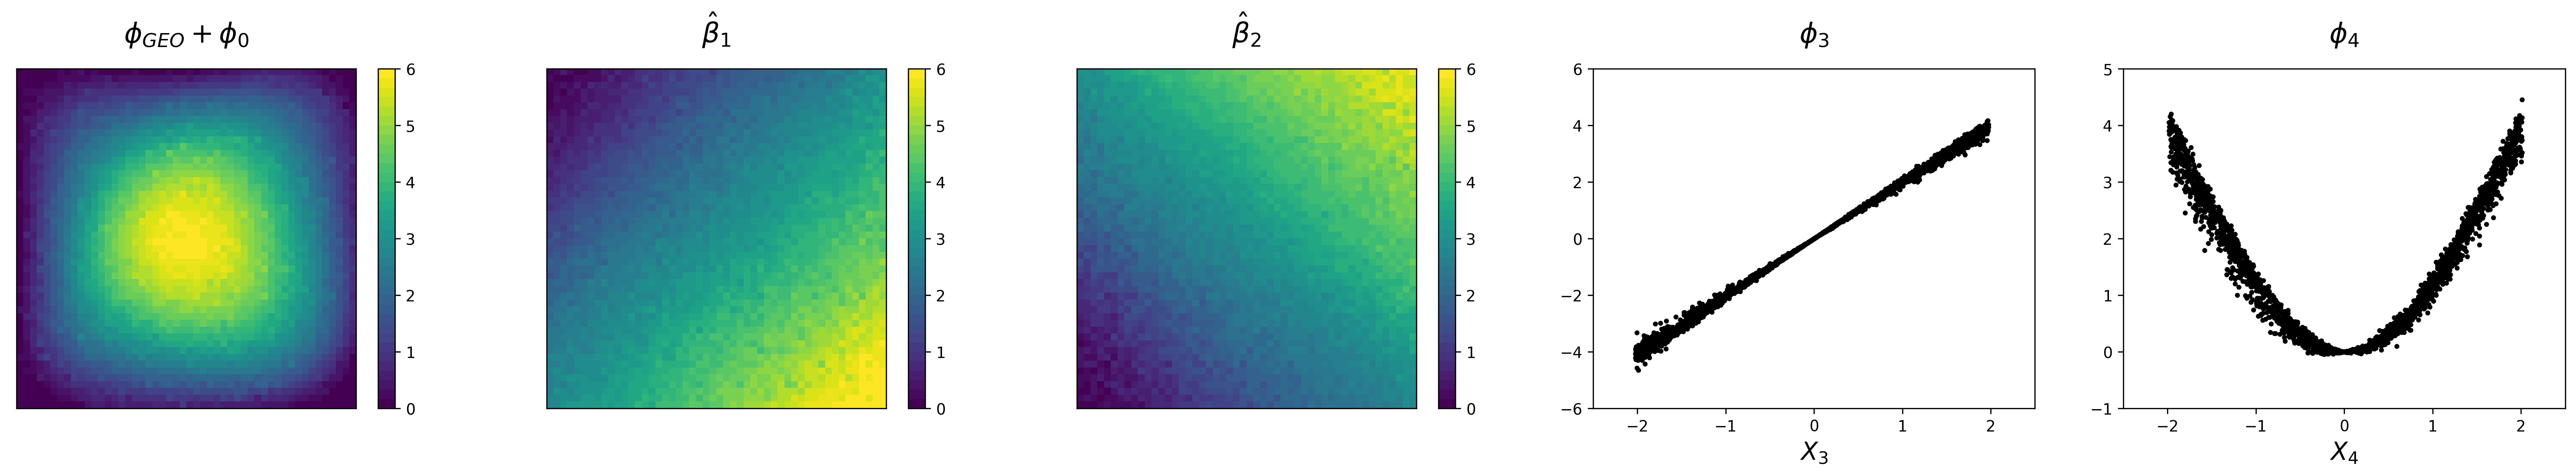

In [80]:
sub_t = [r"$\phi_{GEO}+\phi_{0}$",r"$\hat{\beta}_1$",r"$\hat{\beta}_2$",r"$\phi_{3}$", r"$\phi_{4}$"]

plot_s(mlp_params.T,vmin=0,vmax=6,sub_title=sub_t,title="NN",non_spatial=[[3,X_coords.values[:,2],mlp_params[:,-2],-6,6],
                                       [4,X_coords.values[:,3],mlp_params[:,-1],-1,5]])